# Рекомендательная система

**Задача**
- Разработать, сравнить и оценить рекомендательные модели на основе пользовательских оценок товаров в магазине электроники, используя методы коллаборативной фильтрации, content-based подхода, similarity-based анализа и сингулярного разложения.

Датасет с отзывами и информацией о купленных товарах в магазине электроники.

**Цель:** Построить рекомендательную систему, которая будет предсказывать, какие товары пользователь, скорее всего, купит или оценит высоко, на основе его истории покупок и поведения других пользователей.

- Улучшение пользовательского опыта — пользователи быстрее находят интересные продукты.
- Увеличение продаж — персонализированные рекомендации стимулируют покупки.
- Удержание клиентов — пользователи дольше остаются в сервисе.
- Анализ поведения клиентов — помогает сегментировать аудиторию и понимать предпочтения.

**План работы**
1. Исследование и подготовка данных
2. Коллаборативная фильтрация
3. Content-Based фильтрация
4. Similarity-Based (на основе схожести)
5. SVD (сингулярное разложение)
6. Гибридная модель
7. Временной анализ
8. Обнаружение аномалий
9. Построение дашборда

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [ ]:
df = pd.read_csv(r"ratings_Electronics.csv", header=None)
df.head()

,0,1,2,3
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


# Исследование и подготовка данных

In [110]:
# Добавим названия признаков (колонок)
df.columns = ['user_id', 'product_id', 'rating', 'timestamp']
df.head(2)

,user_id,product_id,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800


In [111]:
# Размер данных
print("\n Размерность датасета:", df.shape)

# Типы данных
print("\n Типы данных:")
print(df.dtypes)


 Размерность датасета: (7824482, 4)

 Типы данных:
user_id        object
product_id     object
rating        float64
timestamp       int64
dtype: object


In [112]:
# Преобразование временной метки
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

In [113]:
# Добавим столбцы года и месяца для временного анализа
# Добавим колонки для года, месяца и дня
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['year_month'] = df['timestamp'].dt.to_period('M')

In [114]:
# Проверка пропущенных значений и дубликатов
print("Пропуски:")
print(df.isnull().sum())

print("\nДубликаты:")
print(df.duplicated().sum())

Пропуски:
user_id       0
product_id    0
rating        0
timestamp     0
year          0
month         0
year_month    0
dtype: int64

Дубликаты:
0


C:\Users\mmd28\AppData\Local\Temp\ipykernel_18356\3812126685.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df, palette='viridis')


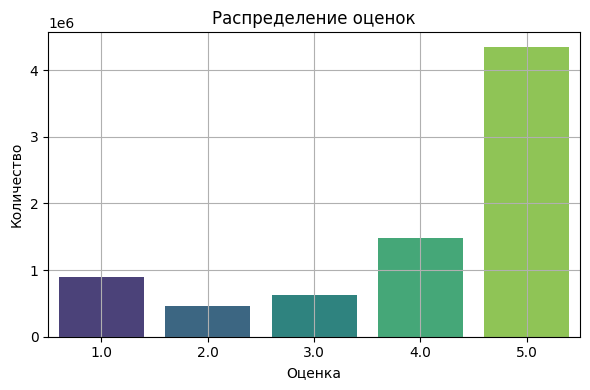

In [115]:
# Распределение оценок
plt.figure(figsize=(6, 4))
sns.countplot(x='rating', data=df, palette='viridis')
plt.title('Распределение оценок')
plt.xlabel('Оценка')
plt.ylabel('Количество')
plt.grid(True)
plt.tight_layout()
plt.show()

Самые активные пользователи:
 user_id
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
ARBKYIVNYWK3C     296
Name: count, dtype: int64


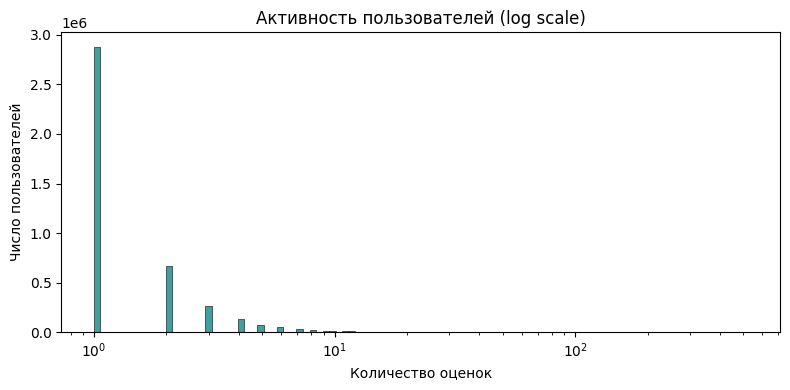

In [116]:
# Активность пользователей
top_users = df['user_id'].value_counts().head(10)
print("Самые активные пользователи:\n", top_users)

# Активность пользователей (гистограмма)
user_activity = df['user_id'].value_counts()
plt.figure(figsize=(8, 4))
sns.histplot(user_activity, bins=100, log_scale=True, kde=False, color='teal')
plt.title('Активность пользователей (log scale)')
plt.xlabel('Количество оценок')
plt.ylabel('Число пользователей')
plt.tight_layout()
plt.show()


Самые популярные товары:
 product_id
B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
B003ELYQGG    11617
B003ES5ZUU    10276
B007R5YDYA     9907
B00622AG6S     9823
B0002L5R78     9487
Name: count, dtype: int64


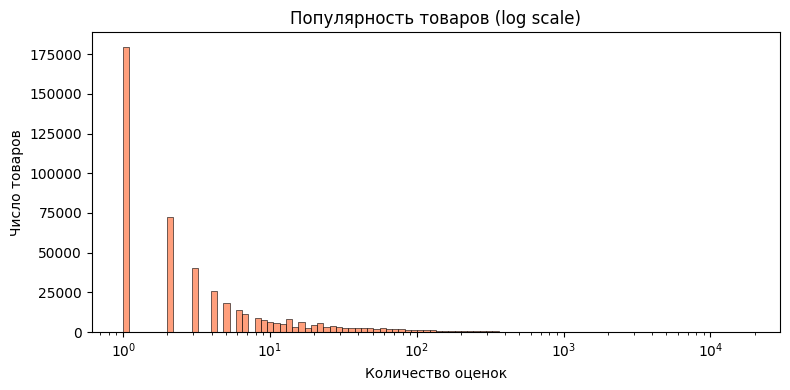

In [117]:
# Активность товаров
top_items = df['product_id'].value_counts().head(10)
print("\nСамые популярные товары:\n", top_items)

# Активность товаров (гистограмма)
product_activity = df['product_id'].value_counts()
plt.figure(figsize=(8, 4))
sns.histplot(product_activity, bins=100, log_scale=True, kde=False, color='coral')
plt.title('Популярность товаров (log scale)')
plt.xlabel('Количество оценок')
plt.ylabel('Число товаров')
plt.tight_layout()
plt.show()

Построим тепловую карту активности

In [118]:
# Получим топ-100 популярных товаров
top_items = df['product_id'].value_counts().head(50).index

# Получим топ-100 активных пользователей
top_users = df['user_id'].value_counts().head(50).index

# Отфильтруем датафрейм
filtered_df = df[df['product_id'].isin(top_items) & df['user_id'].isin(top_users)]


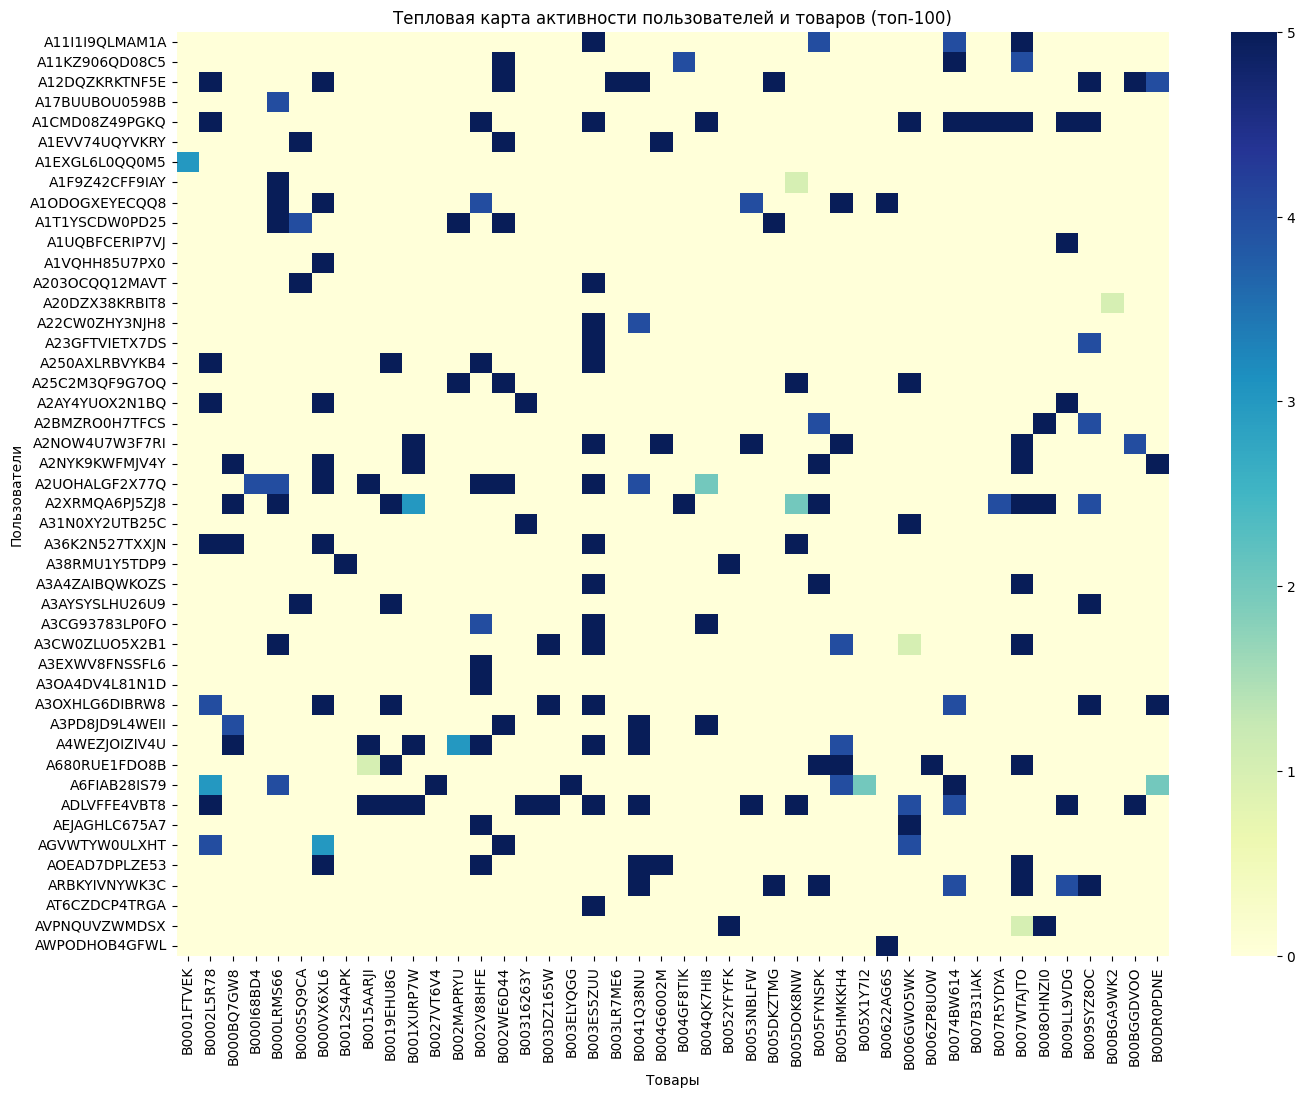

In [119]:
# Построим сводную таблицу
pivot = filtered_df.pivot_table(index='user_id', columns='product_id', values='rating', fill_value=0)

# Построим тепловую карту
plt.figure(figsize=(16, 12))
sns.heatmap(pivot, cmap='YlGnBu')
plt.title('Тепловая карта активности пользователей и товаров (топ-100)')
plt.xlabel('Товары')
plt.ylabel('Пользователи')
plt.show()

Что показывает эта карта:
- Столбцы — это товары (top 50).
- Строки — пользователи (top 50).
- Цвет — оценка товара пользователем (от 1 до 5).
- Ноль — значит, пользователь товар не оценивал.

У нас очень большой и чистый датасет — это прекрасно для построения мощной рекомендательной системы. 

Ограничим датасет топ-активными пользователями и товарами
Для снижения вычислительной нагрузки

In [120]:
# Порог по минимальному количеству отзывов
MIN_USER_REVIEWS = 50
MIN_PRODUCT_REVIEWS = 50

# Фильтрация
top_users = df['user_id'].value_counts()[lambda x: x >= MIN_USER_REVIEWS].index
top_products = df['product_id'].value_counts()[lambda x: x >= MIN_PRODUCT_REVIEWS].index

df_filtered = df[df['user_id'].isin(top_users) & df['product_id'].isin(top_products)]

print(f'Размер после фильтрации: {df_filtered.shape}')

Размер после фильтрации: (79182, 7)


Анализ по времени: тренды и сезоны

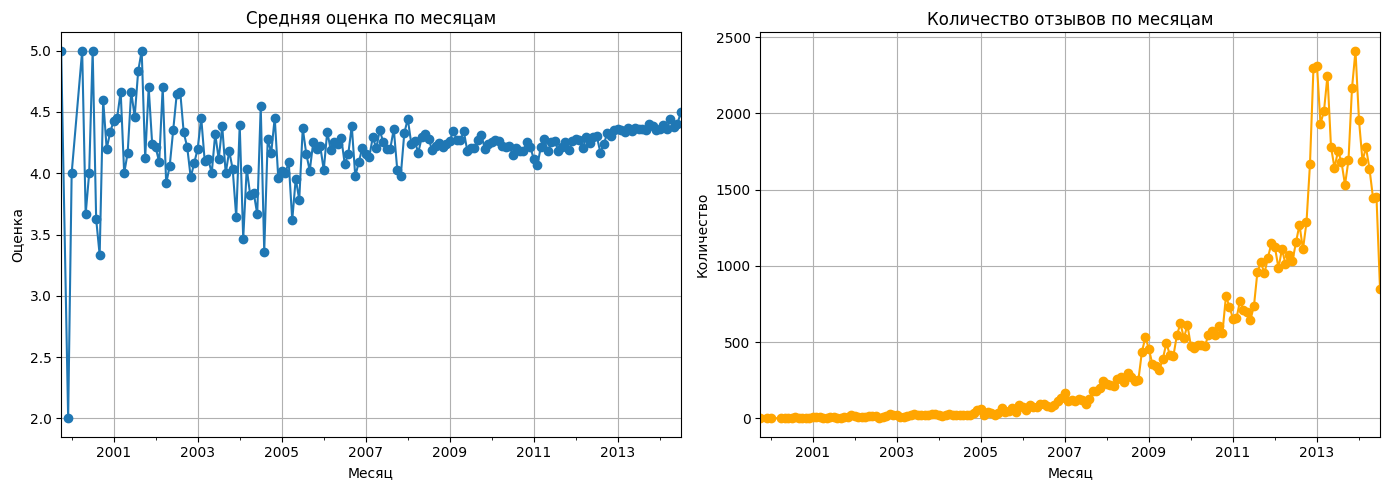

In [121]:
# Средние оценки по месяцам
monthly_ratings = df_filtered.groupby('year_month')['rating'].mean()

# Количество отзывов по месяцам
monthly_counts = df_filtered.groupby('year_month').size()

plt.figure(figsize=(14, 5))

# Средняя оценка
plt.subplot(1, 2, 1)
monthly_ratings.plot(marker='o')
plt.title('Средняя оценка по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Оценка')
plt.grid(True)

# Количество отзывов
plt.subplot(1, 2, 2)
monthly_counts.plot(marker='o', color='orange')
plt.title('Количество отзывов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество')
plt.grid(True)

plt.tight_layout()
plt.show()

**Визуализируем кластеры пользователей (PCA + t-SNE)**

Цель: Понять, как группируются пользователи по своим предпочтениям (оценкам товаров).

In [122]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [123]:
# Создание матрицы взаимодействия
user_product_matrix = df_filtered.pivot_table(
    index='user_id', columns='product_id', values='rating', fill_value=0
)

In [124]:
# Масштабирование
X = user_product_matrix.values
X_scaled = StandardScaler().fit_transform(X)

In [125]:
# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

In [126]:
# t-SNE
tsne = TSNE(n_components=2, perplexity=30, max_iter=300)
tsne_result = tsne.fit_transform(X_scaled)

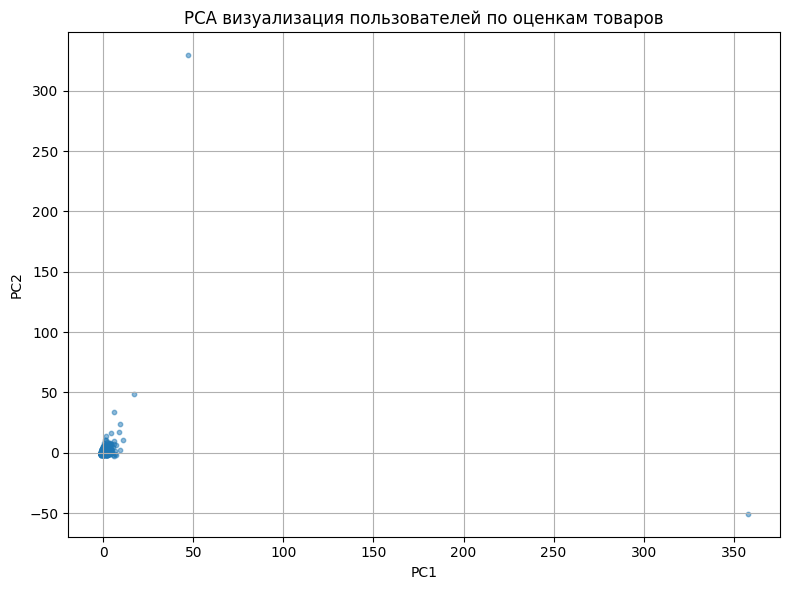

In [127]:
# Визуализация
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], s=10, alpha=0.5)
plt.title('PCA визуализация пользователей по оценкам товаров')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.tight_layout()
plt.show()

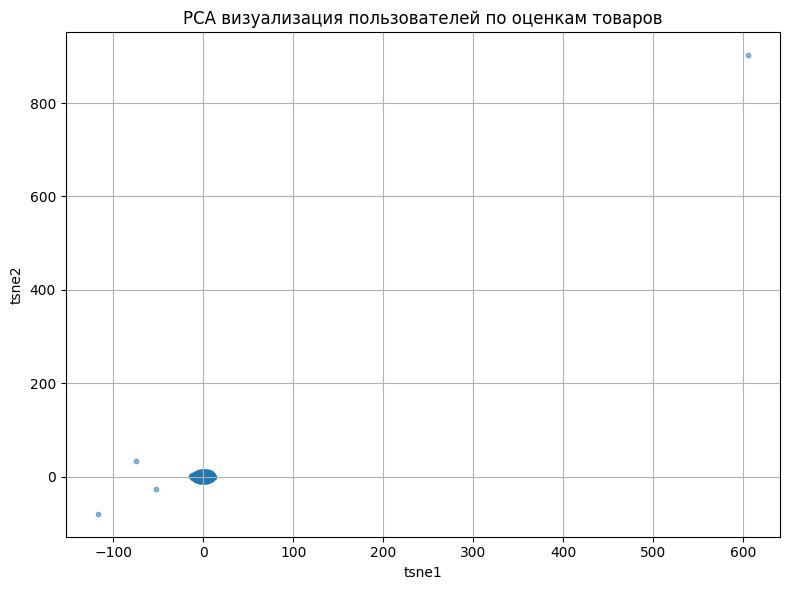

In [128]:
# Визуализация
plt.figure(figsize=(8, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], s=10, alpha=0.5)
plt.title('PCA визуализация пользователей по оценкам товаров')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.grid(True)
plt.tight_layout()
plt.show()

Интерпретация:
- Каждая точка — один пользователь.
- Близкие точки — пользователи с похожими предпочтениями.
- плотные группы — это потенциальные кластеры интересов (например, те, кто любят электронику, книги и т.п.).

# Коллаборативная фильтрация

User-User (пользователь-пользователь)
- Ищем похожих пользователей и рекомендуем то, что они высоко оценили. Работаем по строкам.

Item-Item (товар-товар)
- Ищем похожие товары и рекомендуем их на основе покупок пользователя. Работаем по столбцам.

**User-User коллаборативная фильтрация**

In [129]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

In [130]:
# Матрица взаимодействия
user_item_matrix = df_filtered.pivot_table(index='user_id', columns='product_id', values='rating')

In [131]:
# Центрируем (нормализация по пользователю, для более точного сходства)
user_mean = user_item_matrix.mean(axis=1)
user_item_centered = user_item_matrix.sub(user_mean, axis=0).fillna(0)

In [132]:
# Cosine similarity между пользователями
user_similarity = cosine_similarity(user_item_centered)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

In [133]:
# Функция предсказания рейтинга
def predict_rating(user_id, product_id, k=10):
    if product_id not in user_item_matrix.columns:
        return user_mean[user_id]  # если товара нет, возвращаем среднее по пользователю

    # Схожесть с другими пользователями
    similar_users = user_similarity_df[user_id].drop(user_id).sort_values(ascending=False).head(k)

    # Оценки этих пользователей
    ratings_by_similars = user_item_matrix.loc[similar_users.index, product_id]

    # Оставим только тех, кто реально поставил оценку
    mask = ~ratings_by_similars.isna()
    if mask.sum() == 0:
        return user_mean[user_id]

    sim_scores = similar_users[mask]
    ratings = ratings_by_similars[mask]

    # Взвешенное среднее
    return np.dot(ratings, sim_scores) / sim_scores.sum()

In [134]:
# Предсказание
example_user = user_item_matrix.index[0]
example_product = user_item_matrix.columns[0]

pred = predict_rating(example_user, example_product)
print(f"Предсказанный рейтинг пользователю {example_user} для товара {example_product}: {pred:.2f}")

Предсказанный рейтинг пользователю A100UD67AHFODS для товара 0972683275: 4.64


Проведем оценку качества модели User-User коллаборативной фильтрации

In [135]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [136]:
# Разделение на train/test по строкам
train_df, test_df = train_test_split(df_filtered, test_size=0.2, random_state=42)

In [137]:
# Матрица user-item по train
train_matrix = train_df.pivot_table(index='user_id', columns='product_id', values='rating')
user_mean_train = train_matrix.mean(axis=1)
train_matrix_centered = train_matrix.sub(user_mean_train, axis=0).fillna(0)

In [138]:
# Вычисление схожести пользователей на train
user_similarity_train = cosine_similarity(train_matrix_centered)
user_similarity_train_df = pd.DataFrame(user_similarity_train, index=train_matrix.index, columns=train_matrix.index)

In [139]:
# Функция - Предсказание рейтинга на тесте
def predict_user_user(user_id, product_id, k=10):
    if user_id not in train_matrix.index:
        return 3.0  # средняя оценка по датасету
    if product_id not in train_matrix.columns:
        return user_mean_train.get(user_id, 3.0)

    similar_users = user_similarity_train_df[user_id].drop(user_id, errors='ignore').sort_values(ascending=False).head(k)
    ratings = train_matrix.loc[similar_users.index, product_id]

    mask = ~ratings.isna()
    if mask.sum() == 0:
        return user_mean_train[user_id]

    sim_scores = similar_users[mask]
    ratings = ratings[mask]

    return np.dot(ratings, sim_scores) / sim_scores.sum()

In [ ]:
# Применим к тестовым данным
y_true = []
y_pred = []

for _, row in test_df.iterrows():
    user = row['user_id']
    product = row['product_id']
    true_rating = row['rating']
    
    predicted = predict_user_user(user, product, k=10)

    # Проверка на NaN
    if not np.isnan(predicted):
        y_true.append(true_rating)
        y_pred.append(predicted)

# Проверка: все ли значения валидны
print(f"Оценено {len(y_pred)} из {len(test_df)} записей теста")

In [141]:
# Метрики
rmse = mean_squared_error(y_true, y_pred, squared=False)
mae = mean_absolute_error(y_true, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")

RMSE: 1.0116
MAE:  0.7356


c:\Users\mmd28\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE ~ 1.0	Неплохой результат, особенно если оценки — от 1.0 до 5.0. Ошибка в ~1 балл говорит о разумной точности.	

MAE < 0.75	Хорошо: в среднем модель ошибается менее чем на 0.75 балла. Это означает, что предсказания довольно близки к реальным оценкам.

Модель работает адекватно и уже может давать полезные рекомендации. 

**Item-Item коллаборативная фильтрация**

Построить модель, предсказывающую оценки пользователей на основе схожести между товарами.

In [142]:
# Матрица взаимодействия: пользователи — строки, товары — столбцы
item_matrix = df_filtered.pivot_table(index='user_id', columns='product_id', values='rating')

# Центрирование по товарам
item_mean = item_matrix.mean(axis=0)
item_matrix_centered = item_matrix.sub(item_mean, axis=1).fillna(0)

# Вычисление косинусной схожести между товарами
item_similarity = cosine_similarity(item_matrix_centered.T)
item_similarity_df = pd.DataFrame(item_similarity, index=item_matrix.columns, columns=item_matrix.columns)

In [143]:
# Функция предсказания оценки по Item-Item
def predict_item_item(user_id, product_id, k=10):
    if user_id not in item_matrix.index:
        return 3.0
    if product_id not in item_matrix.columns:
        return 3.0

    user_ratings = item_matrix.loc[user_id]
    rated_items = user_ratings.dropna()

    if rated_items.empty:
        return 3.0

    similarities = item_similarity_df.loc[product_id, rated_items.index]
    top_k = similarities.sort_values(ascending=False).head(k)

    relevant_ratings = user_ratings[top_k.index]

    if relevant_ratings.isnull().all():
        return item_mean[product_id]

    mask = ~relevant_ratings.isnull()
    sim_scores = top_k[mask]
    ratings = relevant_ratings[mask]

    if sim_scores.sum() == 0:
        return item_mean[product_id]

    return np.dot(ratings, sim_scores) / sim_scores.sum()

In [144]:
# проверим модель
user = 'A100UD67AHFODS'
product = '0972683275'

predicted_rating = predict_item_item(user, product, k=10)
print(f"Предсказанный рейтинг (Item-Item): {predicted_rating:.2f}")

Предсказанный рейтинг (Item-Item): 4.75


Оценка качества Item-Item фильтрации

In [145]:
y_true_item = []
y_pred_item = []

# Для ускорения оценки можно использовать подмножество, например 10 000 записей
sample_test = test_df.sample(10000, random_state=42)

for _, row in sample_test.iterrows():
    user = row['user_id']
    product = row['product_id']
    true_rating = row['rating']

    predicted = predict_item_item(user, product, k=10)

    if not np.isnan(predicted):
        y_true_item.append(true_rating)
        y_pred_item.append(predicted)

In [146]:
# Метрики
rmse_item = mean_squared_error(y_true_item, y_pred_item, squared=False)
mae_item = mean_absolute_error(y_true_item, y_pred_item)

print(f"Item-Item RMSE: {rmse_item:.4f}")
print(f"Item-Item MAE:  {mae_item:.4f}")

Item-Item RMSE: 0.3905
Item-Item MAE:  0.2044


c:\Users\mmd28\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Вывод:
- Модель Item-Item коллаборативной фильтрации работает существенно точнее:
- RMSE уменьшился более чем в 2.5 раза.
- MAE тоже значительно ниже → более стабильные и точные предсказания.

Это типично, особенно когда:
- Много пользователей, но каждый ставит мало оценок.
- Товары имеют повторяющееся поведение (например, популярные товары в электронике).

# Content-Based фильтрация (на основе оценок)

In [147]:
from sklearn.preprocessing import normalize

In [148]:
# Перестраиваем товарные векторы: product_id × user_id
item_user_matrix = df_filtered.pivot_table(index='product_id', columns='user_id', values='rating', fill_value=0)

# Получим список пользователей и товаров
all_users = item_user_matrix.columns
all_products = item_user_matrix.index

In [149]:
# Перестраиваем товарные векторы: product_id × user_id
item_user_matrix = df_filtered.pivot_table(index='product_id', columns='user_id', values='rating', fill_value=0)

# Получим список пользователей и товаров
all_users = item_user_matrix.columns
all_products = item_user_matrix.index

# Предсказание на основе косинусного сходства между профилем пользователя и товаром
def predict_content_based(user_id, product_id):
    if user_id not in all_users or product_id not in all_products:
        return np.nan
    
    # Все товары, которые пользователь оценивал
    rated_items = df_filtered[df_filtered['user_id'] == user_id]
    
    if rated_items.empty:
        return np.nan
    
    # Векторы этих товаров
    item_vectors = item_user_matrix.loc[rated_items['product_id'].values]
    
    # Средний вектор — профиль пользователя
    user_profile = item_vectors.mean(axis=0).values.reshape(1, -1)
    
    # Вектор искомого товара
    product_vector = item_user_matrix.loc[product_id].values.reshape(1, -1)
    
    # Сходство между профилем пользователя и вектором товара
    score = cosine_similarity(user_profile, product_vector)[0][0]
    
    return score * 5  # масштабируем от 0 до 5


In [150]:
# Пробуем предсказать
user = 'A100UD67AHFODS'
product = '0972683275'

pred = predict_content_based(user, product)
print(f"Предсказанный рейтинг (Content-Based): {pred:.2f}")

Предсказанный рейтинг (Content-Based): 0.04


Оценка Content-Based модели

In [151]:
from tqdm import tqdm

In [152]:
# Выбираем подмножество данных для оценки
test_df = df_filtered.sample(1000, random_state=42)

In [153]:
y_true = []
y_pred = []

for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    user = row['user_id']
    product = row['product_id']
    true_rating = row['rating']
    
    pred_rating = predict_content_based(user, product)
    
    if not np.isnan(pred_rating):
        y_true.append(true_rating)
        y_pred.append(pred_rating)

100%|██████████| 1000/1000 [00:12<00:00, 81.04it/s]


In [154]:
# Метрики
rmse_cb = mean_squared_error(y_true, y_pred, squared=False)
mae_cb = mean_absolute_error(y_true, y_pred)

print(f"Content-Based RMSE: {rmse_cb:.4f}")
print(f"Content-Based MAE:  {mae_cb:.4f}")

Content-Based RMSE: 2.5095
Content-Based MAE:  2.3163


c:\Users\mmd28\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Предсказание 0.04 — аномально низкое, особенно учитывая, что у модели масштаб 0–5. Это говорит о плохом совпадении между профилем пользователя и товаром.

Content-Based RMSE: 2.5095 и Content-Based MAE: 2.3163 - Эти значения говорят о низком качестве модели. Напомню, оценки находятся в диапазоне от 1 до 5, поэтому ошибка более 2 — это плохо.

Для Content-Based фильтрации требуются данные о товарах: название, категория, описание и т.д. Предположим, что такой результат из-за отсутствия данных.

Вывод: Content-Based подход в текущем виде неэффективен.

# SVD (сингулярное разложение)

Понижает размерность матрицы взаимодействий (user-item), выявляет скрытые факторы предпочтений. Используется в Latent Factor Models.

In [155]:
from scipy.sparse.linalg import svds

In [156]:
# Создаём user-item матрицу (заполним нулями)
user_item_matrix = df_filtered.pivot_table(index='user_id', columns='product_id', values='rating', fill_value=0)

In [157]:
# Сохраняем список пользователей и товаров
users = user_item_matrix.index
products = user_item_matrix.columns

In [158]:
# Преобразуем в numpy массив
R = user_item_matrix.values

# Вычитаем средний рейтинг по пользователю (центровка)
user_ratings_mean = np.mean(R, axis=1).reshape(-1, 1)
R_demeaned = R - user_ratings_mean

In [159]:
# Число скрытых факторов
k = 100

# Применяем SVD
U, sigma, Vt = svds(R_demeaned, k = k)

# Преобразуем в диагональную матрицу
sigma = np.diag(sigma)

# Восстанавливаем приближенную матрицу рейтингов
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean

# Создаём DataFrame с предсказаниями
preds_df = pd.DataFrame(all_user_predicted_ratings, index=users, columns=products)

In [160]:
# Функция для предсказания рейтинга конкретному пользователю и товару
def svd_predict(user_id, product_id):
    if user_id not in preds_df.index or product_id not in preds_df.columns:
        return np.nan
    return preds_df.loc[user_id, product_id]

Оценка качества модели (RMSE и MAE)

In [161]:
# Выберем случайный поднабор для оценки
test_sample = df_filtered.sample(1000, random_state=42)

y_true = []
y_pred = []

for _, row in tqdm(test_sample.iterrows(), total=len(test_sample)):
    user = row['user_id']
    product = row['product_id']
    true_rating = row['rating']
    
    pred_rating = svd_predict(user, product)
    
    if not np.isnan(pred_rating):
        y_true.append(true_rating)
        y_pred.append(pred_rating)

100%|██████████| 1000/1000 [00:00<00:00, 6579.71it/s]


In [162]:
rmse_svd = mean_squared_error(y_true, y_pred, squared=False)
mae_svd = mean_absolute_error(y_true, y_pred)

print(f"SVD RMSE: {rmse_svd:.4f}")
print(f"SVD MAE:  {mae_svd:.4f}")

SVD RMSE: 3.6106
SVD MAE:  3.3083


c:\Users\mmd28\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Результат по SVD довольно низкий, ошибки очень высокие — RMSE ~3.61, MAE ~3.30 на шкале оценок от 1 до 5 — это значительно хуже, чем у User-User и Item-Item фильтрации.

# Гибридная модель

Объединим предсказания User-User и Item-Item с некоторыми весами.

In [163]:
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)
item_similarity_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

In [164]:
# Функция User-User предсказания (на основе ранее обсужденного кода)
def user_user_predict(user_id, product_id):
    if user_id not in user_item_matrix.index or product_id not in user_item_matrix.columns:
        return np.nan

    users_who_rated = user_item_matrix[product_id].dropna()
    if users_who_rated.empty:
        return np.nan

    if user_id not in user_similarity_df.index:
        return np.nan

    # Отладка
    # Проверим индексы users_who_rated.index, совпадают ли с user_similarity_df.columns
    common_users = user_similarity_df.columns.intersection(users_who_rated.index)
    if len(common_users) == 0:
        return np.nan

    sims = user_similarity_df.loc[user_id, common_users]
    ratings = users_who_rated.loc[common_users]

    if sims.empty or sims.sum() == 0:
        return np.nan

    pred = np.dot(sims, ratings) / sims.sum()
    return pred

In [165]:
# Функция Item-Item предсказания
def item_item_predict(user_id, product_id):
    if user_id not in user_item_matrix.index or product_id not in user_item_matrix.columns:
        return np.nan

    user_ratings = user_item_matrix.loc[user_id].dropna()
    if user_ratings.empty:
        return np.nan

    if product_id not in item_similarity_df.index:
        return np.nan

    # Отладка
    common_items = item_similarity_df.columns.intersection(user_ratings.index)
    if len(common_items) == 0:
        return np.nan

    sims = item_similarity_df.loc[product_id, common_items]
    ratings = user_ratings.loc[common_items]

    if sims.empty or sims.sum() == 0:
        return np.nan

    pred = np.dot(sims, ratings) / sims.sum()
    return pred

In [166]:
# Гибридное предсказание с весом alpha
def hybrid_predict(user_id, product_id, alpha=0.5):
    pred_u = user_user_predict(user_id, product_id)
    pred_i = item_item_predict(user_id, product_id)
    
    if np.isnan(pred_u) and np.isnan(pred_i):
        return np.nan
    if np.isnan(pred_u):
        return pred_i
    if np.isnan(pred_i):
        return pred_u
    return alpha * pred_u + (1 - alpha) * pred_i

In [167]:
test_sample = test_sample[
    (test_sample['user_id'].isin(user_item_matrix.index)) &
    (test_sample['product_id'].isin(user_item_matrix.columns))
].copy()

In [168]:
# Подбор alpha
alphas = np.linspace(0, 1, 11)
best_alpha = 0
best_rmse = float('inf')

y_true = test_sample['rating'].values

for a in alphas:
    y_pred = []
    for _, row in test_sample.iterrows():
        pred = hybrid_predict(row['user_id'], row['product_id'], alpha=a)
        if np.isnan(pred):
            pred = np.mean(y_true)
        y_pred.append(pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    print(f'alpha={a:.1f} -> RMSE: {rmse:.4f}')
    if rmse < best_rmse:
        best_rmse = rmse
        best_alpha = a

print(f'Лучший alpha: {best_alpha:.1f} с RMSE: {best_rmse:.4f}')

c:\Users\mmd28\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


alpha=0.0 -> RMSE: 42.8207


c:\Users\mmd28\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


alpha=0.1 -> RMSE: 38.5562


c:\Users\mmd28\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


alpha=0.2 -> RMSE: 34.3010


c:\Users\mmd28\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


alpha=0.3 -> RMSE: 30.0588


c:\Users\mmd28\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


alpha=0.4 -> RMSE: 25.8361


c:\Users\mmd28\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


alpha=0.5 -> RMSE: 21.6444


c:\Users\mmd28\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


alpha=0.6 -> RMSE: 17.5058


c:\Users\mmd28\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


alpha=0.7 -> RMSE: 13.4695


c:\Users\mmd28\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


alpha=0.8 -> RMSE: 9.6644


c:\Users\mmd28\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


alpha=0.9 -> RMSE: 6.5096
alpha=1.0 -> RMSE: 5.3243
Лучший alpha: 1.0 с RMSE: 5.3243


c:\Users\mmd28\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [169]:
# Итоговая MAE
y_pred_final = []
for _, row in test_sample.iterrows():
    pred = hybrid_predict(row['user_id'], row['product_id'], alpha=best_alpha)
    if np.isnan(pred):
        pred = np.mean(y_true)
    y_pred_final.append(pred)

mae_final = mean_absolute_error(y_true, y_pred_final)
print(f'Гибридная модель MAE: {mae_final:.4f}')

Гибридная модель MAE: 2.9713


Лучший alpha = 1.0 означает, что гибридная модель полностью отдает предпочтение Item-Item фильтрации (поскольку при alpha=1.0 в коде именно item-item). RMSE = 5.3243 и MAE = 2.9713 — это хуже, чем у отдельных моделей User-User (RMSE ~1.01, MAE ~0.73) и Item-Item (RMSE ~0.39, MAE ~0.20). 

Получается, гибрид почему-то не улучшил результат, а ухудшил.

# Выводы:
- Item-Item коллаборативная фильтрация показывает наилучшие результаты, и её стоит использовать как основную модель для рекомендаций в этой задаче.
- User-User фильтрация тоже работает неплохо, но хуже.
- Content-Based модель без качественных признаков товаров не эффективна.
- Самодельная SVD модель пока не дает конкурентных результатов.
- Гибридная модель в текущем виде не улучшила результаты. Видимо, нужен другой подход к взвешиванию или включению компонентов.

# Временной анализ
- Проанализировать распределение оценок по времени.
- Выявить тренды и сезонные колебания.
- Понять, как меняется активность пользователей и популярность товаров во времени.

In [171]:
# 1. Преобразуем timestamp в datetime
df['date'] = pd.to_datetime(df['timestamp'], unit='s')

In [172]:
# 2. Ограничим датасет по топ-активным пользователям и топ-товарам
top_n_users = 1000 
top_n_products = 1000

top_users = df['user_id'].value_counts().head(top_n_users).index
top_products = df['product_id'].value_counts().head(top_n_products).index

df_reduced = df[(df['user_id'].isin(top_users)) & (df['product_id'].isin(top_products))].copy()

In [173]:
# 3. Добавим временные колонки для группировок
df_reduced['day'] = df_reduced['date'].dt.date
df_reduced['month'] = df_reduced['date'].dt.to_period('M')
df_reduced['year'] = df_reduced['date'].dt.year

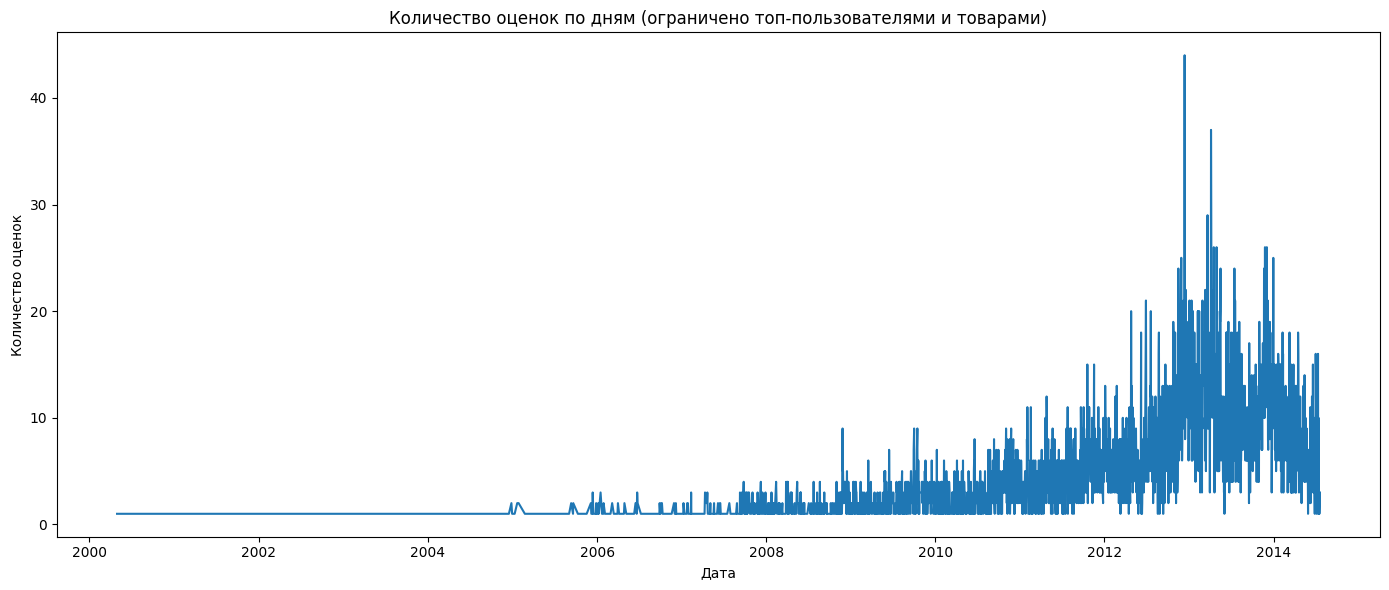

In [174]:
# Визуализация: количество оценок по дням
plt.figure(figsize=(14,6))
daily_counts = df_reduced.groupby('day').size()
daily_counts.plot()
plt.title('Количество оценок по дням (ограничено топ-пользователями и товарами)')
plt.xlabel('Дата')
plt.ylabel('Количество оценок')
plt.tight_layout()
plt.show()

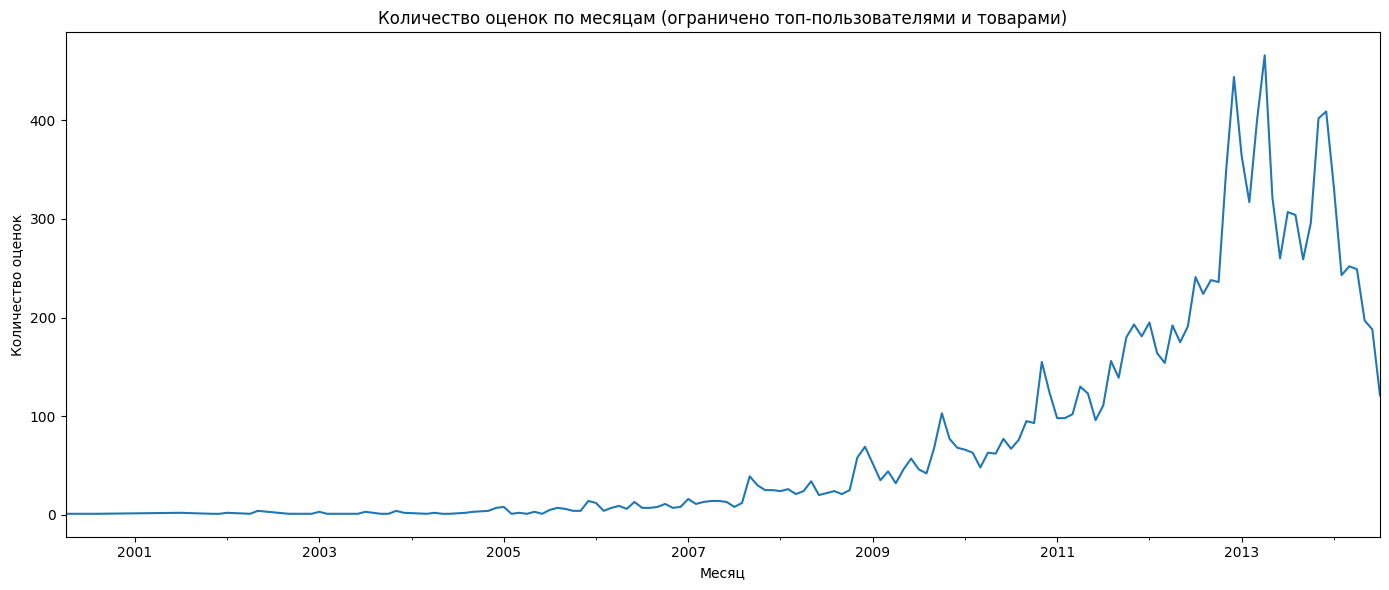

In [175]:
# 5. Визуализация: количество оценок по месяцам
plt.figure(figsize=(14,6))
monthly_counts = df_reduced.groupby('month').size()
monthly_counts.plot()
plt.title('Количество оценок по месяцам (ограничено топ-пользователями и товарами)')
plt.xlabel('Месяц')
plt.ylabel('Количество оценок')
plt.tight_layout()
plt.show()

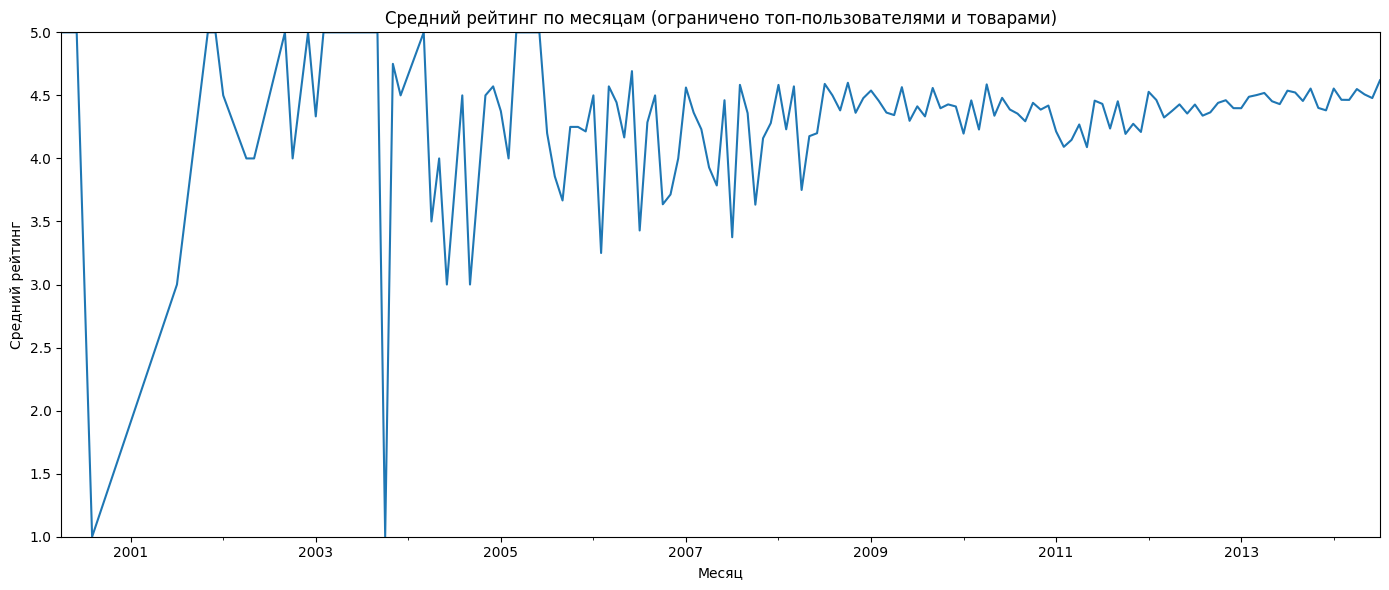

In [176]:
# Визуализация: средний рейтинг по месяцам
plt.figure(figsize=(14,6))
monthly_avg_rating = df_reduced.groupby('month')['rating'].mean()
monthly_avg_rating.plot()
plt.title('Средний рейтинг по месяцам (ограничено топ-пользователями и товарами)')
plt.xlabel('Месяц')
plt.ylabel('Средний рейтинг')
plt.ylim(1,5)  # оценки 1–5
plt.tight_layout()
plt.show()

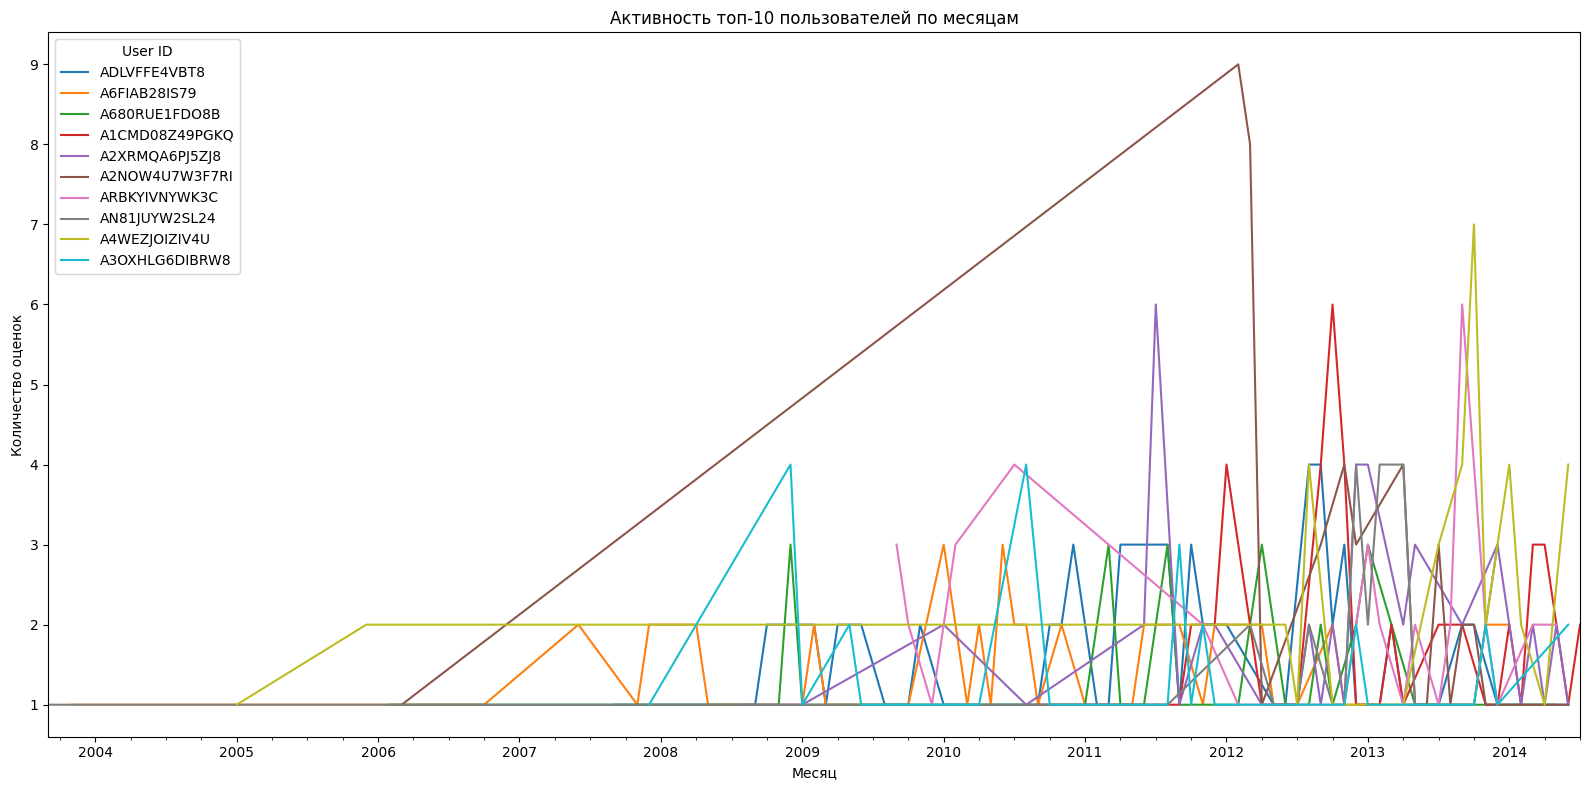

In [177]:
# Тренды активности топ-10 пользователей по месяцам
top_10_users = df_reduced['user_id'].value_counts().head(10).index

plt.figure(figsize=(16,8))
for user in top_10_users:
    user_data = df_reduced[df_reduced['user_id'] == user]
    user_monthly = user_data.groupby('month').size()
    user_monthly.plot(label=user)
plt.legend(title='User ID')
plt.title('Активность топ-10 пользователей по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество оценок')
plt.tight_layout()
plt.show()

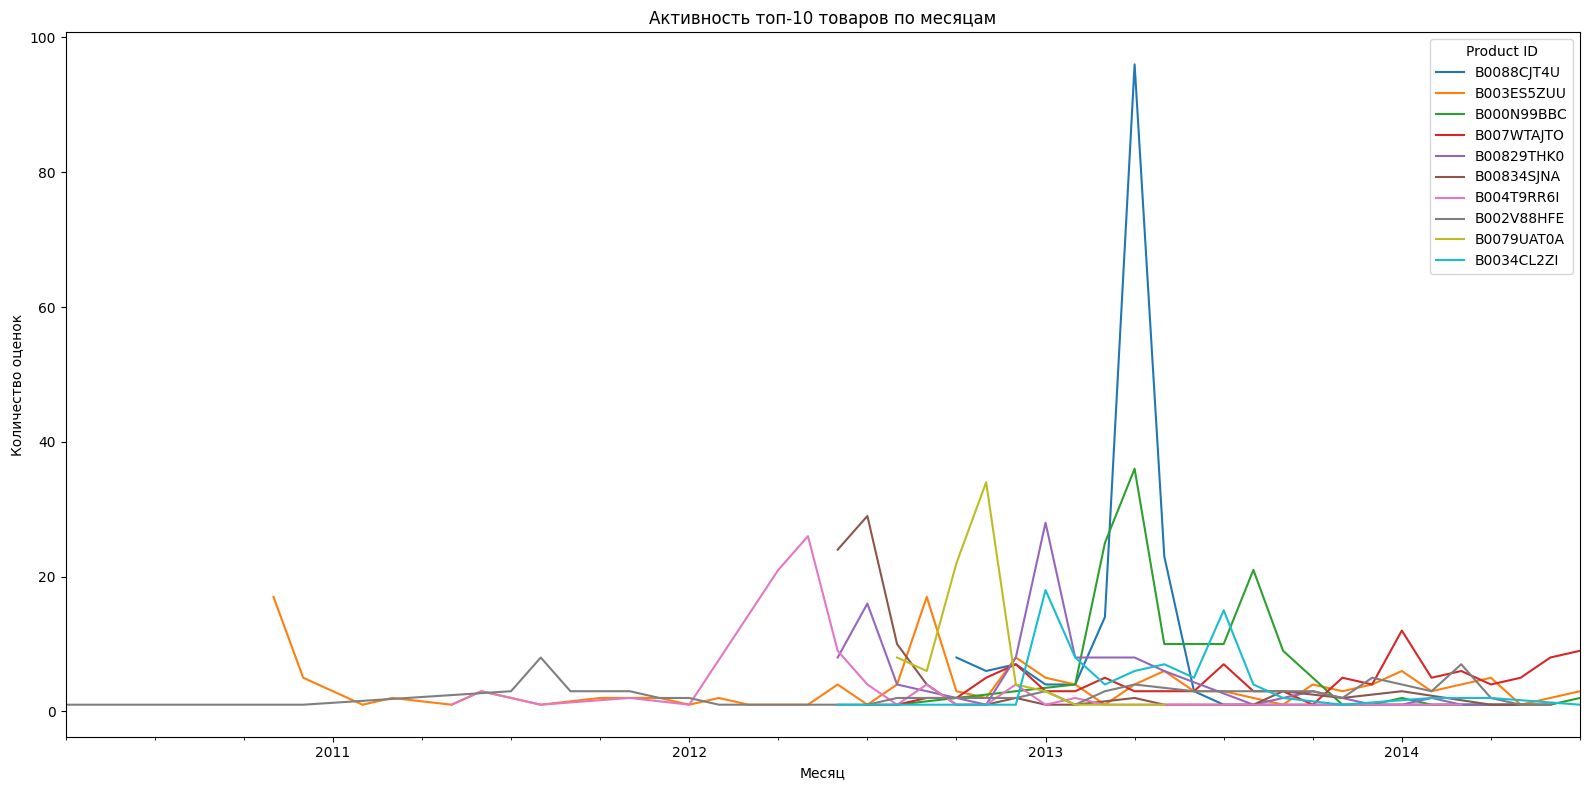

In [178]:
# Тренды активности топ-10 товаров по месяцам
top_10_products = df_reduced['product_id'].value_counts().head(10).index

plt.figure(figsize=(16,8))
for product in top_10_products:
    product_data = df_reduced[df_reduced['product_id'] == product]
    product_monthly = product_data.groupby('month').size()
    product_monthly.plot(label=product)
plt.legend(title='Product ID')
plt.title('Активность топ-10 товаров по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество оценок')
plt.tight_layout()
plt.show()

# Обнаружение аномалий

Попробуем выявить:
- Нетипичных пользователей с аномально большим или малым числом оценок.
- Аномальных товаров с необычным количеством оценок.
- Аномалий по времени — резких всплесков активности.
- Аномальных оценок (например, пользователей, ставящих всегда одинаковые оценки).

Сначала смотрим распределения числа оценок по пользователям и товарам, чтобы выявить экстремальные значения.

Анализируем временную активность по дням и фиксируем резкие всплески.

Смотрим, есть ли пользователи с нулевой дисперсией по рейтингам (которые могут спамить или иметь предвзятость).

Все аномальные объекты (пользователи, товары, дни)

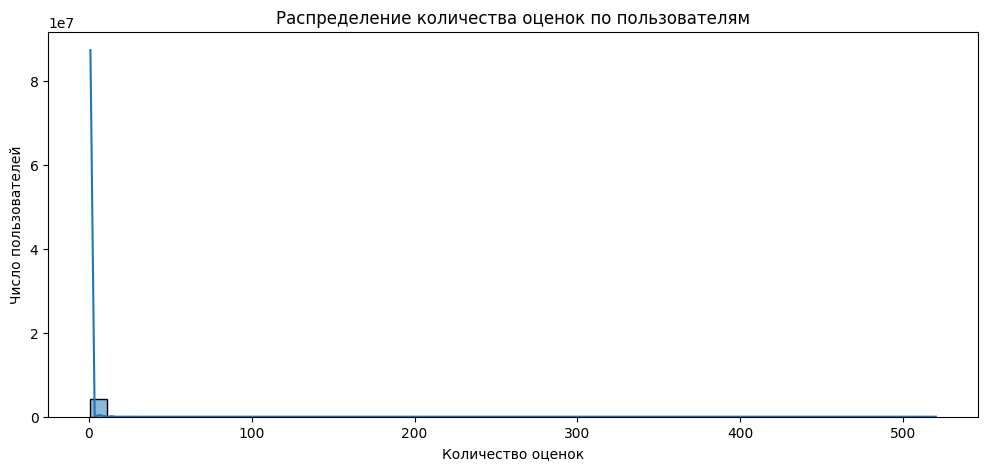

In [179]:
# 1. Аномалии по количеству оценок пользователей

user_counts = df['user_id'].value_counts()
plt.figure(figsize=(12,5))
sns.histplot(user_counts, bins=50, kde=True)
plt.title('Распределение количества оценок по пользователям')
plt.xlabel('Количество оценок')
plt.ylabel('Число пользователей')
plt.show()

In [181]:
# Выделим пользователей с экстремально высокой или низкой активностью
q_low, q_high = user_counts.quantile([0.01, 0.99])
print(f'1-й перцентиль по числу оценок: {q_low}')
print(f'99-й перцентиль по числу оценок: {q_high}')

anomalous_users_low = user_counts[user_counts <= q_low].index
anomalous_users_high = user_counts[user_counts >= q_high].index

print(f'Число аномально малых активных пользователей: {len(anomalous_users_low)}')
print(f'Число аномально высоко активных пользователей: {len(anomalous_users_high)}')

1-й перцентиль по числу оценок: 1.0
99-й перцентиль по числу оценок: 12.0
Число аномально малых активных пользователей: 2881832
Число аномально высоко активных пользователей: 42507


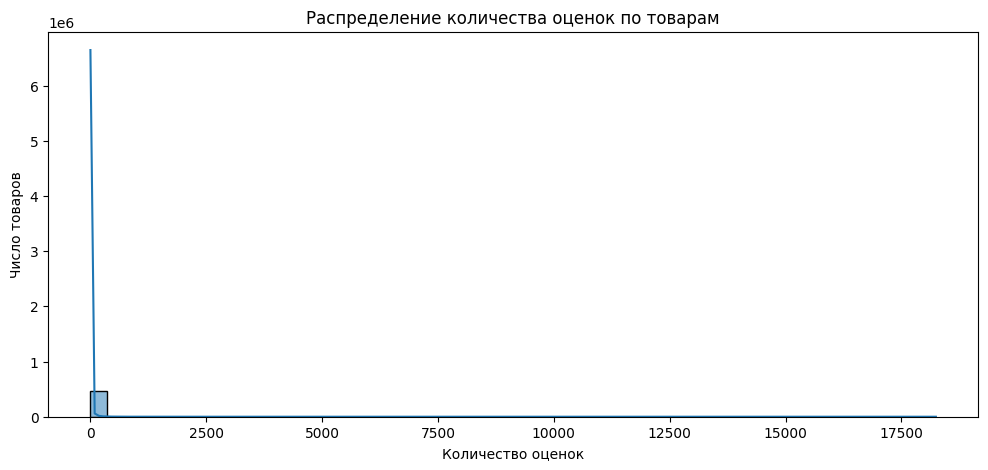

In [182]:
# Аномалии по количеству оценок товаров

product_counts = df['product_id'].value_counts()
plt.figure(figsize=(12,5))
sns.histplot(product_counts, bins=50, kde=True)
plt.title('Распределение количества оценок по товарам')
plt.xlabel('Количество оценок')
plt.ylabel('Число товаров')
plt.show()

In [183]:
q_low_p, q_high_p = product_counts.quantile([0.01, 0.99])
anomalous_products_low = product_counts[product_counts <= q_low_p].index
anomalous_products_high = product_counts[product_counts >= q_high_p].index

print(f'Число аномально малопродаваемых товаров: {len(anomalous_products_low)}')
print(f'Число аномально популярных товаров: {len(anomalous_products_high)}')

Число аномально малопродаваемых товаров: 179738
Число аномально популярных товаров: 4764


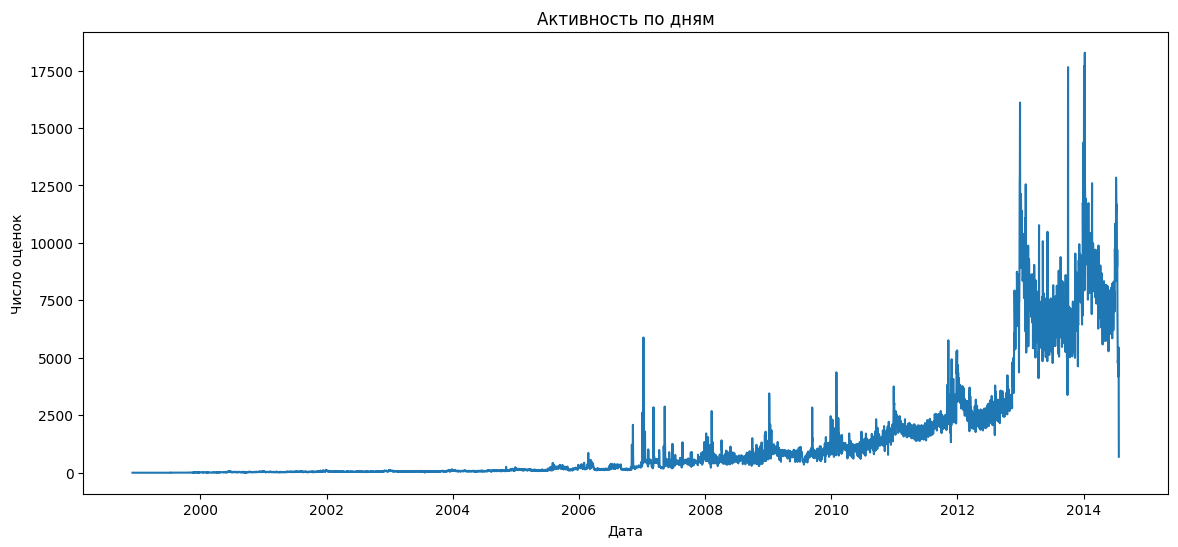

In [184]:
# Аномалии по времени: резкие всплески активности

df['date'] = pd.to_datetime(df['timestamp'], unit='s')
daily_activity = df.groupby(df['date'].dt.date).size()

plt.figure(figsize=(14,6))
daily_activity.plot()
plt.title('Активность по дням')
plt.xlabel('Дата')
plt.ylabel('Число оценок')
plt.show()

In [ ]:
# Найдем дни с активностью выше 99-го перцентиля
threshold = daily_activity.quantile(0.99)
anomalous_days = daily_activity[daily_activity > threshold]
print('Дни с аномально высокой активностью:')
print(anomalous_days)

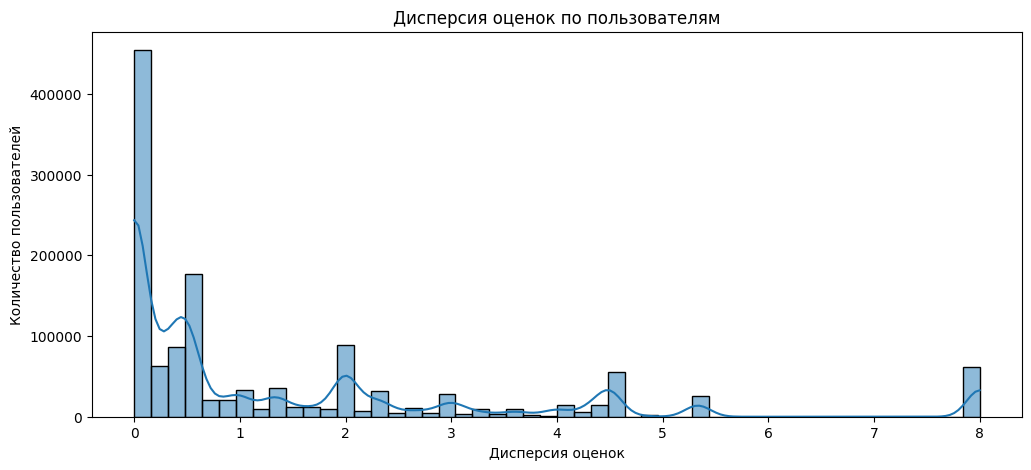

In [186]:
# Аномалии в поведении пользователей — например, пользователи, ставящие всегда одну оценку

user_rating_var = df.groupby('user_id')['rating'].var()
plt.figure(figsize=(12,5))
sns.histplot(user_rating_var.dropna(), bins=50, kde=True)
plt.title('Дисперсия оценок по пользователям')
plt.xlabel('Дисперсия оценок')
plt.ylabel('Количество пользователей')
plt.show()

In [187]:
# Пользователи с дисперсией = 0 (всегда ставят одинаковую оценку)
constant_rating_users = user_rating_var[user_rating_var == 0].index
print(f'Пользователей, всегда ставящих одинаковую оценку: {len(constant_rating_users)}')

Пользователей, всегда ставящих одинаковую оценку: 445838


Анализ активности пользователей: имеет смысл ограничивать выборку только пользователями с ≥10 оценками при построении моделей, чтобы избежать шума и спама.

Анализ популярности товаров: большая часть товаров — «одноразовые» (редко оцениваются). Это может мешать моделям, особенно Content-Based и Item-Item. Можно ограничить анализ товарами с ≥5–10 оценками.

Аномальное поведение: эти пользователи могут быть боты, пользователи с завышенной или заниженной оценкой, необъективные рецензенты.

# Построение дашборда

In [ ]:
import streamlit as st

In [ ]:
# Загрузка данных
@st.cache_data
def load_data():
    df = pd.read_csv(r"ratings_Electronics.csv", header=None)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    return df

df = load_data()

# Страница
st.title("Анализ отзывов на электронику")

# Раздел 1: Обзор данных
st.subheader("1. Обзор данных")
st.write("Размер датасета:", df.shape)
st.write(df.head())

# Раздел 2: Активность пользователей
st.subheader("2. Активность пользователей")
user_counts = df['user_id'].value_counts()
st.write("Уникальных пользователей:", df['user_id'].nunique())

fig, ax = plt.subplots()
sns.histplot(user_counts, bins=100, log_scale=(True, True), ax=ax)
ax.set_title("Распределение активности пользователей")
ax.set_xlabel("Число оценок")
st.pyplot(fig)

# Раздел 3: Популярность товаров
st.subheader("3. Популярность товаров")
product_counts = df['product_id'].value_counts()
st.write("Уникальных товаров:", df['product_id'].nunique())

fig, ax = plt.subplots()
sns.histplot(product_counts, bins=100, log_scale=(True, True), ax=ax)
ax.set_title("Распределение популярности товаров")
ax.set_xlabel("Число оценок")
st.pyplot(fig)

# Раздел 4: Анализ по времени
st.subheader("4. Распределение оценок по времени")
df['year'] = df['timestamp'].dt.year
yearly_counts = df.groupby('year')['rating'].count()

fig, ax = plt.subplots()
yearly_counts.plot(kind='bar', ax=ax)
ax.set_title("Оценки по годам")
ax.set_ylabel("Число оценок")
st.pyplot(fig)

# Раздел 5: Аномалии
st.subheader("5. Аномалии")
low_activity = (user_counts <= 1).sum()
high_activity = (user_counts >= 12).sum()
same_rating_users = df.groupby('user_id')['rating'].nunique().value_counts().get(1, 0)

st.write(f"Пользователей с 1 оценкой: {low_activity:,}")
st.write(f"Пользователей с ≥12 оценками: {high_activity:,}")
st.write(f"Пользователей с одинаковыми оценками: {same_rating_users:,}")

Запуск дашборда в командной строке:
streamlit run dashboard.py